# Model A

Checkpoint 2: Mandatory Check-In

- Research Questions (1.5%).
- Feature Engineering (2%).
- Modeling Approaches (3%).
- Preliminary Results (1%).


## Import Libraries

In [ ]:
import cv2
import re
import io
import os
import pickle
import zipfile
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

COLAB = True

# mount Colab drive and set library path
if COLAB:
  import sys
  from google.colab import drive
  drive.mount('/content/drive')
  path = '/content/drive/My Drive/Colab Notebooks/grad_project'
  data_dir = f'{path}/Data'
  sys.path.insert(0, f'{path}/Source') # for colab to see local libraries
else:
  data_dir = f'../Data'


from data_utils import read_files_from_zip, data2pd, show_balance, load_model_data, save_model_data
from feature_utils import crop_and_fill
from eda_utils import show_image


from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import data

In [ ]:
%%time

# Set Date Source
data_file = f'{data_dir}/sp24_grad_project_data.zip'

# Load Test Images
test_data_images = read_files_from_zip(data_file, r'(test)_images_([\w-]*)\.npz')

# Load Train Images and Labels
train_data_images = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_images\.npz')
train_data_labels = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_labels\.npy')

# Convert to Dataframe
train_df = data2pd(train_data_images, train_data_labels)
test_df = data2pd(test_data_images)

# Clean up
del(test_data_images)
del(train_data_images)
del(train_data_labels)

Importing data from zip: 100%|██████████| 2/2 [00:07<00:00,  3.99s/it]


Found the following datasets:  ['hurricane-matthew', 'flooding-fire']


Importing data from zip: 100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


Found the following datasets:  ['socal-fire', 'midwest-flooding', 'hurricane-matthew']


Importing data from zip: 100%|██████████| 3/3 [00:00<00:00, 745.65it/s]

Found the following datasets:  ['socal-fire', 'midwest-flooding', 'hurricane-matthew']
CPU times: user 21.4 s, sys: 4.07 s, total: 25.5 s
Wall time: 32.1 s


In [ ]:
print('Train label balance:')
show_balance(train_df)

Train label balance:


type       label
fire       0        7204
           3        1064
           1          69
           2          43
flood      0        6734
           1         114
           2          97
           3          59
hurricane  1        5236
           0        2631
           3        1740
           2        1544
Name: count, dtype: int64

## Data Cleansing Plan

There are many potential enhancements, this seems a reasonable starting point.

 - Scale images to 180x180 (ResNet50 default)
 - Normalize pixel values from 0-255 to be float from 0-1
 - For Type Classifier, encode level+type to float between -1 and 1
 - For Level Classifier, ohe level to catagories 0-4
 - When undersampling, sample without replacement within innerquartile
 - When oversampling, include entire set then sample with replacement and augmentation


### Model Task A

Data split and augmentation plan (Disaster Type Classification)

We'll use a mix of oversampling and undersampling...

 - oversample the minority class using replacement
 - undersample by randomly delete rows from the majority class to match
 - think about how to use Neighborhood Cleaning Under Sampling...
   
 - Validation:
     - Sample without replacement 8 samples of each disaster type/level
 - Training:
     - fire:3 has the most (1064-8) representation,
     - flood:1 the next largest (114-8) representation and
     - fire:2 has the least (43-8).

In [ ]:
# Feature Engineering

# Add a size column
def get_size(img):
    dim = img.shape
    return dim[0] * dim[1]
train_df['size'] = train_df['image'].apply(get_size)

# Show size feature and range
print(train_df.columns)
train_df[['size']].describe().T

Index(['index', 'type', 'image', 'label', 'size'], dtype='object')


,count,mean,std,min,25%,50%,75%,max
size,26535.0,8169.871867,12364.717747,84.0,1936.0,4340.0,10240.0,410464.0


In [ ]:
# Create dataset for Disaster Type Classification
classify_type_df = train_df[(train_df.type == 'fire') | (train_df.type == 'flood')]
show_balance(classify_type_df)
classify_type_df.shape

type   label
fire   0        7204
       3        1064
       1          69
       2          43
flood  0        6734
       1         114
       2          97
       3          59
Name: count, dtype: int64

(15384, 5)

In [ ]:
# Create validation set for modelling.

# We would like for our test set to representive of our population so...
# we'll limit it sizes in the innerquartile.
#
# Also, since we don't have must data we want to lose as litte as possible...
# so, we do our validataion k-folds manually.
#
# We're also selecting only samples that have sizes within the
# innerquartile to choose the 'most' representative.

def get_validation_set(classify_type_df):
    sample_size = 8

    classify_type_valid_df = pd.DataFrame()
    print('Before: ',classify_type_df.shape)
    for T in classify_type_df.type.unique(): # T for type
        for L in classify_type_df.label.unique(): # L for label
            if (L==0):
                this_sample_size = sample_size//2
            else:
                this_sample_size = sample_size
            sample_df =  classify_type_df[
                    (classify_type_df['type'] == T) & (classify_type_df['label'] == L)
                    & ((classify_type_df['size'] <= 10240) & (classify_type_df['size'] >= 1936))
                ].sample(this_sample_size)
            classify_type_valid_df = pd.concat([sample_df, classify_type_valid_df])
    classify_type_df = classify_type_df.drop(index=classify_type_valid_df.index)
    return classify_type_valid_df, classify_type_df



classify_type_valid_df, classify_train_valid_df = get_validation_set(classify_type_df)
show_balance(classify_type_valid_df)

Before:  (15384, 5)


type   label
fire   1        8
       2        8
       3        8
       0        4
flood  1        8
       2        8
       3        8
       0        4
Name: count, dtype: int64

In [ ]:
# We ought to try SMOTE instead but we wanted to try this manual approach first...
# We really need to squeeze out as much unique data as possible...
# because there isn't much to work with.

from feature_utils import augment_image

# Now augment data until balanced.
# We'll use a mix of oversampling and undersampling...
# - oversample the minority class using replacement
# - undersample by randomly delete rows from the majority class to match

def get_train_set(classify_type_df, classify_type_valid_df):
    classify_type_train_df = pd.DataFrame()

    # Drop the validation set before sampling
    classify_type_df = classify_type_df.drop(index=classify_type_valid_df.index)

    # Set a reasonable argumentation limit
    sample_size = 150 #int(114 * 1.32)

    # We apply flip, rotate augmentation to the
    # sample with replacement samples.
    # We might duplicate an augmentation if the
    # same record is sampled and the augmentation
    # is applied.

    for T in classify_type_df.type.unique():
        for L in classify_type_df.label.unique():
            if L==0:
                this_sample_size = sample_size//2
            else:
                this_sample_size = sample_size
            record_size = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)].shape[0]
            if (record_size > this_sample_size):
                sample_df = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)].sample(this_sample_size)
            else:
                sample_df = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)]
                classify_type_train_df = pd.concat([sample_df, classify_type_train_df])
                sample_df = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)].sample(this_sample_size-record_size, replace=True)
                sample_df['image'] = sample_df['image'].apply(augment_image)
            classify_type_train_df = pd.concat([sample_df, classify_type_train_df])
    return classify_type_train_df


classify_type_train_df = get_train_set(classify_type_df, classify_type_valid_df)
show_balance(classify_type_train_df)

type   label
fire   1        150
       2        150
       3        150
       0         75
flood  1        150
       2        150
       3        150
       0         75
Name: count, dtype: int64

In [ ]:
# Alternately use SMOTE
"""
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Flatten the images for SMOTE
X_train_flatten = X_train.reshape((X_train.shape[0], -1))

# Convert one-hot encoded labels to single label for SMOTE
le = LabelEncoder()
Y_train_single = le.fit_transform([np.argmax(y, axis=None, out=None) for y in Y_train])

# Apply SMOTE
smote = SMOTE()
X_train_smote, Y_train_smote = smote.fit_resample(X_train_flatten, Y_train_single)

# Reshape the images back to original shape
X_train_smote = X_train_smote.reshape((X_train_smote.shape[0], image_dim, image_dim, 3))

# Convert single label back to one-hot encoding
Y_train_smote = to_categorical(Y_train_smote, num_classes=4)
"""

---

## Feature Engineering

Recall our Tasks:

**Disaster Type Classification**
 -  The goal is to build a classifier that can automatically categorize images based on the type of disaster scenario, such as flooding or fire.
   
**Damage Level Classification**
 - The objective is to create a classifier that can automatically determine the level of building damage following a disaster, specifically for hurricanes.

For now we've only added size and used it for undersampling.
These are images so we'll let Gauss do his thing...
...try not to second guess Gauss.


## Modeling

Let's cookup a the simplest model we can think of...
For us this a autoencoder where we encoding our convolved image into a latent space then decode to our classes.

**Task A**
 - Reshape (180x180, normalize for positive definteness)
 - Conv2d (180x180)
 - MaxPooling2D (60x60, Dense, ReLu)
 - Dropout
 - Flatten
 - Dense (10 classes) flood or fire and levels 0-3

### Model Task A

In [ ]:
# Recall our datasets

print(len(classify_type_valid_df), len(classify_type_train_df))

56 1050


In [ ]:
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

Encode Labels and Resize Images for modeling.

Note: In general changing aspect ratios show little effect on the ablity of CNNs to learn.  We note changing the aspect ratio increases the number of epochs to train to some loss threshold.  This implies that for simpiler models might benifit from preserving the aspect ratio.

Things to consider:
 - A model might memorize the low-dimension aspect-ratio rather than high-dimensional image-features.
 - Consider the balance of compute, memory and time it takes for model to converge.
 - Train with cropped large images and zero-background centered small images.
 - Make a more extractable model, for example use 2d convolution for each color then apply SVG. Plot labels using PCA dimensions.

In [ ]:
# Encode Labels and Resize Images for modeling.
import cv2

def encode_type(type_df):
    # -1:flood, +1:fire
    type_df['type_code'] = type_df[['type','label']].apply(lambda df: df['label'] if df['type']=='fire' else -df['label'], axis=1)
    type_df['type_code'] = type_df['type_code']/type_df['type_code'].abs().max()
    X = type_df['image'].to_list()
    X = np.array([cv2.resize(img, (180, 180)) for img in X])
    Y = type_df['type_code']
    return X,Y

X_valid, Y_valid = encode_type(classify_type_valid_df)
X_train, Y_train = encode_type(classify_type_train_df)

In [ ]:
backend.clear_session()  # clear model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import get_custom_objects



# Define the model
model = Sequential([
    # Rescaling layer
    #layers.Rescaling(1./255, input_shape=(None, None, 3)),
    layers.BatchNormalization(),

    # Resize layer
    layers.Resizing(180, 180),

    # Conv2D layer (1st)
    layers.Conv2D(32, (3, 3), activation='relu'),

    # MaxPooling2D layer
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dense(64, activation='relu'),

    # Dropout layer
    layers.Dropout(0.2),

    # Conv2D layer (2nd)
    layers.Conv2D(32, (3, 3), activation='relu'),

    # MaxPooling2D layer
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dense(64, activation='relu'),

    # Dropout layer
    layers.Dropout(0.2),

    # Conv2D layer (3rd)
    layers.Conv2D(32, (3, 3), activation='relu'),

    # MaxPooling2D layer
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dense(64, activation='relu'),

    # Dropout layer
    layers.Dropout(0.2),

    # Flatten layer
    layers.Flatten(),

    # Dense layer with linear activation for regression
    layers.Dense(1, activation='linear')
])


# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')  # w/o custom layer
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Nope

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 resizing_1 (Resizing)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 dense_4 (Dense)             (None, 89, 89, 64)        2112      
                                                                 
 dropout_3 (Dropout)         (None, 89, 89, 64)        0         
                                                      

In [ ]:
# While we created two splits of the data it
# cause some major overfitting problems, so
# we'll train with just one.
# We're getting 95% across the board as it, so well be fine.  ;-)


# We use transfer leraning so that we only have to train once
model_0, history_0, notes_0 = load_model_data('model_0', path=data_dir)
if model_0 != None:
    model, model_history, notes = model_0, history_0, notes_0
else:
    # Fit
    model_history = model.fit(X_train, Y_train,
                              validation_data = (X_valid, Y_valid),
                              epochs=20, batch_size=132,
                              verbose = 1)
    # Save, one and done.
    save_model_data('model_0', model, model_history, 'trained on balanced labels', path=data_dir)

/content/drive/My Drive/Colab Notebooks/grad_project/Data/models/model_0
/content/drive/My Drive/Colab Notebooks/grad_project/Data/models/model_0/history.pkl
Model not found.
Epoch 1/20
8/8 [==============================] - 108s 13s/step - loss: 0.4540 - val_loss: 0.4383
Epoch 2/20
8/8 [==============================] - 88s 10s/step - loss: 0.4273 - val_loss: 0.4012
Epoch 3/20
8/8 [==============================] - 78s 10s/step - loss: 0.3792 - val_loss: 0.3876
Epoch 4/20
8/8 [==============================] - 81s 10s/step - loss: 0.3395 - val_loss: 0.3606
Epoch 5/20
8/8 [==============================] - 77s 10s/step - loss: 0.2868 - val_loss: 0.2445
Epoch 6/20
8/8 [==============================] - 80s 10s/step - loss: 0.2458 - val_loss: 0.2689
Epoch 7/20
8/8 [==============================] - 79s 10s/step - loss: 0.2166 - val_loss: 0.2627
Epoch 8/20
8/8 [==============================] - 80s 10s/step - loss: 0.1815 - val_loss: 0.3015
Epoch 9/20
8/8 [==============================] 

In [60]:
# Define a custom activation function
# ... the idea is that we wanted to train a linear model with no damage
# to create a greater seperation for our binary classifier.
def custom_activation(y):
    return tf.where(y > 0, 1, 0)

prediction = model.predict(X_valid)
prediction = tf.squeeze(custom_activation(prediction)) # sometimes to just want to hug a squeeze your tensors
actual = custom_activation(Y_valid)

2/2 [==============================] - 2s 1s/step


In [61]:
prediction, actual # visually this looks pretty good

(<tf.Tensor: shape=(56,), dtype=int32, numpy=
 array([1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(56,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int32)>)

In [62]:
np.sum(prediction==0,axis=0), np.sum(prediction==1,axis=0) # nice an balances

(20, 36)

In [63]:
# remember our activation is greater than zero,
# thus we have 8 more zero values, as expected.
np.sum(actual==0,axis=0), np.sum(actual==1,axis=0)

(32, 24)

In [64]:
def plot_loss(History):
    history = History.history
    N = len(history["loss"])
    plt.figure(figsize = (7, 7))
    plt.plot(np.arange(0, N), history["loss"], label = "train_loss", ls = '--')
    plt.plot(np.arange(0, N), history["val_loss"], label = "val_loss", ls = '--')
    #plt.yscale('log')
    plt.title("Loss vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.grid()

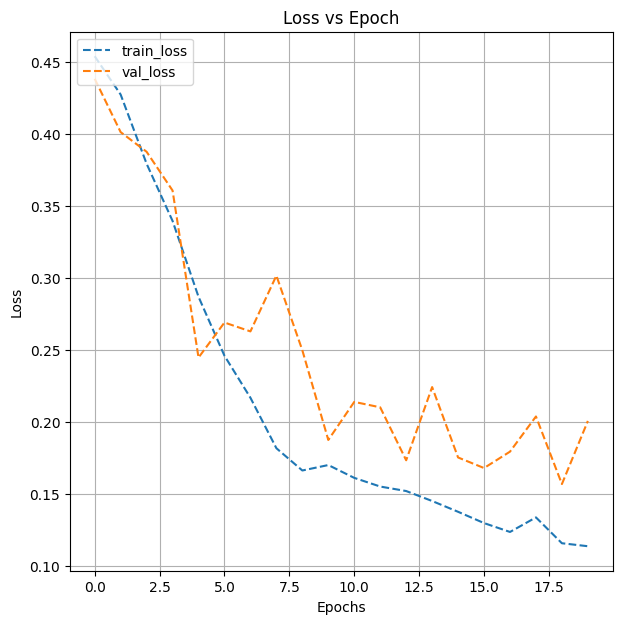

In [65]:
plot_loss(model_history)

              precision    recall  f1-score   support

           0     0.9500    0.5938    0.7308        32
           1     0.6389    0.9583    0.7667        24

    accuracy                         0.7500        56
   macro avg     0.7944    0.7760    0.7487        56
weighted avg     0.8167    0.7500    0.7462        56



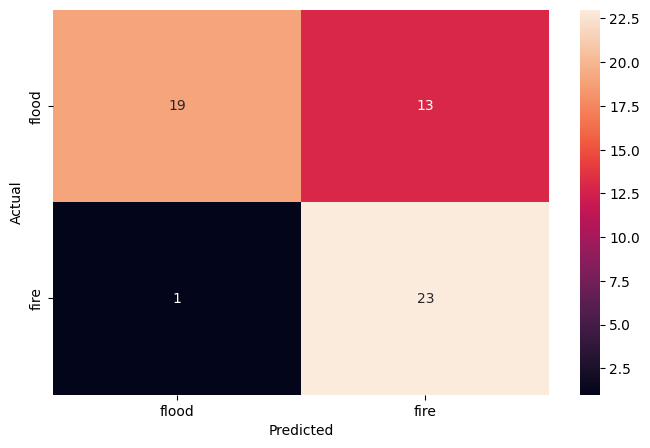

In [67]:
# Evaluate our model based on precision, recall, and f1-score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Printing the classification report
print(classification_report(actual, prediction, digits=4))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(actual, prediction)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f',
          xticklabels = ['flood', 'fire'],
          yticklabels = ['flood', 'fire'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [68]:
# Create dataset for Disaster Type Classification
actual_df = train_df[((train_df.type == 'fire') | (train_df.type == 'flood')) & (train_df.label != 0)].copy()
show_balance(actual_df)

type   label
fire   3        1064
       1          69
       2          43
flood  1         114
       2          97
       3          59
Name: count, dtype: int64

In [69]:
# -1:flood, +1:fire
actual_df['type_code'] = actual_df[['type','label']].apply(lambda df: df['label'] if df['type']=='fire' else -df['label'], axis=1)
actual_df['type_code'] = actual_df['type_code']/actual_df['type_code'].abs().max()

X_actual = actual_df['image'].to_list()
X_actual = np.array([cv2.resize(img, (180, 180)) for img in X_actual])
Y_actual = actual_df['type_code']

In [70]:
prediction = model.predict(X_actual)
prediction = tf.squeeze(custom_activation(prediction)) # give the tensor a hug and squeeze
actual = custom_activation(Y_actual)

46/46 [==============================] - 26s 564ms/step


              precision    recall  f1-score   support

           0     0.9683    0.6778    0.7974       270
           1     0.9308    0.9949    0.9618      1176

    accuracy                         0.9357      1446
   macro avg     0.9495    0.8363    0.8796      1446
weighted avg     0.9378    0.9357    0.9311      1446



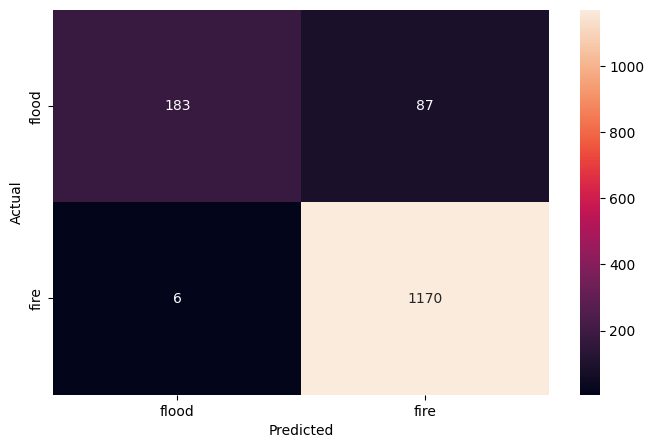

In [71]:
# Evaluate our model based on precision, recall, and f1-score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Printing the classification report
print(classification_report(actual, prediction, digits=4))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(actual, prediction)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f',
          xticklabels = ['flood', 'fire'],
          yticklabels = ['flood', 'fire'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 resizing_1 (Resizing)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 dense_4 (Dense)             (None, 89, 89, 64)        2112      
                                                                 
 dropout_3 (Dropout)         (None, 89, 89, 64)        0         
                                                      

## Notes and Resources

https://learningds.org/ch/19/class_pred.html

https://neptune.ai/blog/keras-loss-functions

https://www.h2kinfosys.com/blog/linear-classifier-with-tensorflow-keras/

Deep Learning with Python, by François Chollet

https://github.com/fchollet/deep-learning-with-python-notebooks/

Python Data Science Handbook, by Jake VanderPlas

https://github.com/jakevdp/PythonDataScienceHandbook